# COVID-19 Chest X-Ray Classification

## Dataset Analysis

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os

### Class Distribution

Count the number of images in each class to check for imbalance.

In [2]:
data_dir = './dataset'
classes = ['covid', 'lung-opacity', 'normal', 'viral-pneumonia']
for cls in classes:
    path = os.path.join(data_dir, cls)
    count = len(os.listdir(path))
    print(f"{cls}: {count} images")

covid: 3616 images
lung-opacity: 6012 images
normal: 10192 images
viral-pneumonia: 1345 images


**Observations:**
- Dataset is imbalanced: Normal class has most images (10,192), Viral Pneumonia has least (1,345)
- Total: 21,165 X-ray images across 4 classes
- Will need to handle class imbalance during training

### Image Format Check

In [3]:
img_path = os.path.join(data_dir, 'covid', os.listdir(os.path.join(data_dir, 'covid'))[0])
img = Image.open(img_path)
print(f"Mode: {img.mode}")  # 'L' = grayscale, 'RGB' = 3-channel
print(f"Size: {img.size}")

Mode: L
Size: (299, 299)


**Observation:**
- Images are in grayscale format (mode: 'L')
- Need to convert to 3-channel RGB for pretrained models
- Will use 'Grayscale(num_output_channels=3)' in transforms

### Sample Images from Each Class

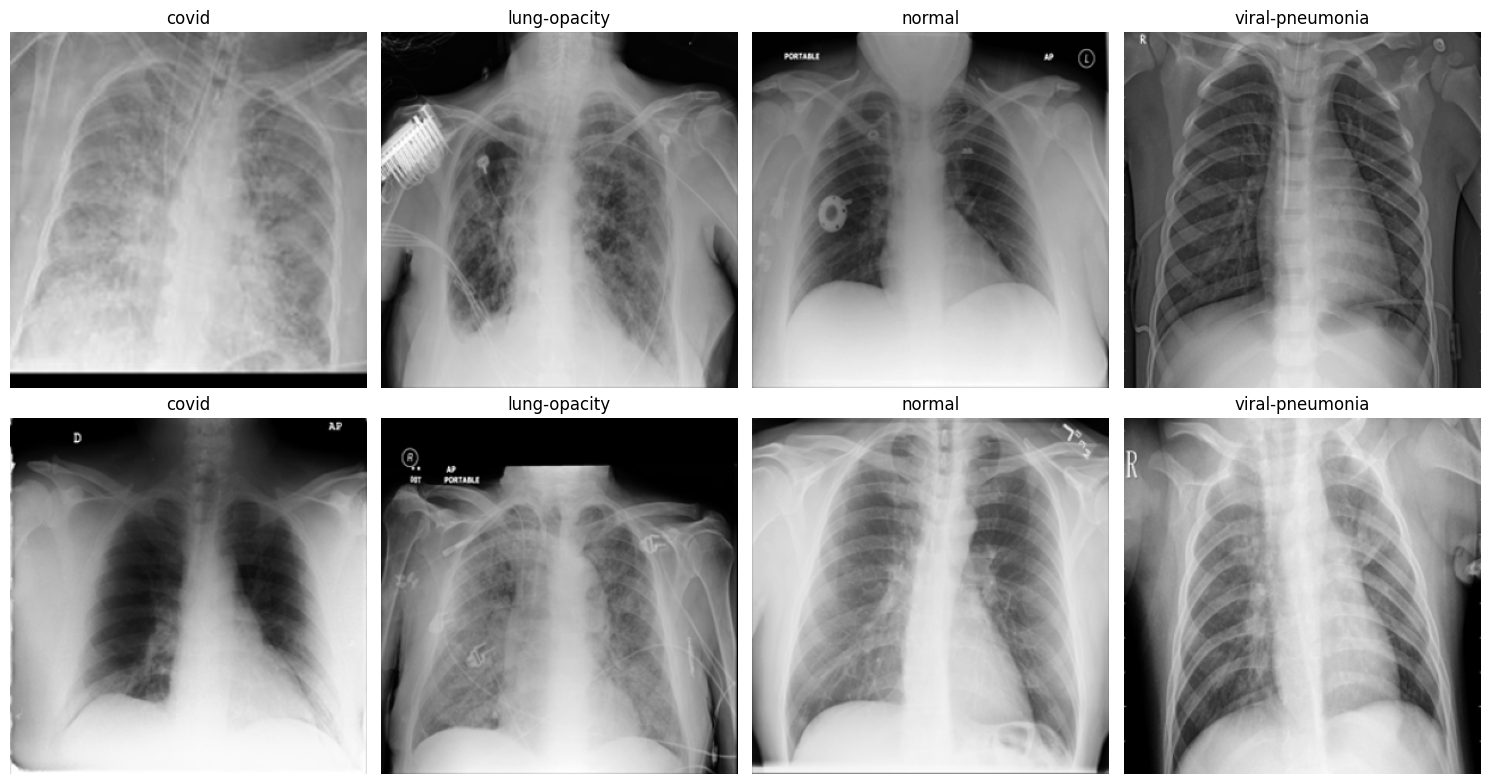

In [4]:
fig, axes = plt.subplots(2, 4, figsize=(15,8))

for i, cls in enumerate(classes):
    path = os.path.join(data_dir, cls)
    imgs = os.listdir(path)[:2]

    for j, img_name in enumerate(imgs):
        img = Image.open(os.path.join(path, img_name))
        axes[j, i].imshow(img, cmap='gray')
        axes[j, i].set_title(cls)
        axes[j, i].axis('off')

plt.tight_layout()
plt.show()

## Data Preparation

### Data Transforms

Using ResNet18 pretrained on ImageNet, which requires:
- Input size: 224×224
- ImageNet normalization (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

Minimal augmentation for medical data integrity (slight brightness/contrast variation only).

In [5]:
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### Load Dataset

Loading all images using ImageFolder, which automatically assigns labels based on folder names.

In [6]:
temp_dataset = datasets.ImageFolder(data_dir)
targets = np.array(temp_dataset.targets)

n = len(temp_dataset)
print(f"Total images: {n}")
print(f"Classes: {temp_dataset.classes}")

Total images: 21165
Classes: ['covid', 'lung-opacity', 'normal', 'viral-pneumonia']


### Train/Validation/Test Split

Using stratified split (70/15/15) to maintain class distribution across all sets.

In [7]:
# 70% train, 30% temp (which will become val+test)
train_idx, temp_idx = train_test_split(
    range(n), 
    test_size=0.3, 
    stratify=targets,
    random_state=42
)

# Split temp into 50-50 (15% val, 15% test of total)
temp_targets = targets[temp_idx]
val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.5,
    stratify=temp_targets,
    random_state=42
)

print(f"Train: {len(train_idx)} ({len(train_idx)/n*100:.1f}%)")
print(f"Val: {len(val_idx)} ({len(val_idx)/n*100:.1f}%)")
print(f"Test: {len(test_idx)} ({len(test_idx)/n*100:.1f}%)")

Train: 14815 (70.0%)
Val: 3175 (15.0%)
Test: 3175 (15.0%)


### Create Train/Val/Test Datasets

Creating separate dataset instances for each split with appropriate transforms.

In [8]:
train_dataset = Subset(
    datasets.ImageFolder(data_dir, transform=train_transform),
    train_idx
)

val_dataset = Subset(
    datasets.ImageFolder(data_dir, transform=val_test_transform),
    val_idx
)

test_dataset = Subset(
    datasets.ImageFolder(data_dir, transform=val_test_transform),
    test_idx
)

print(f"Train dataset: {len(train_dataset)} images")
print(f"Val dataset: {len(val_dataset)} images")
print(f"Test dataset: {len(test_dataset)} images")

Train dataset: 14815 images
Val dataset: 3175 images
Test dataset: 3175 images


### DataLoaders

Creating DataLoaders for batched training and evaluation.

In [9]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 232
Val batches: 50
Test batches: 50


## Model Setup

Using pretrained ResNet18 with modified final layer for 4 classes.

In [12]:
# Load pretrained ResNet18
model = models.resnet18(weights='DEFAULT')

# Modify final layer for 4 classes
model.fc = nn.Linear(model.fc.in_features, 4)

# Move to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print(f"Using device: {device}")
print(f"Model output layer: {model.fc}")

Using device: cuda
Model output layer: Linear(in_features=512, out_features=4, bias=True)


### Loss Function and Optimizer

Using class weights to handle dataset imbalance.

In [13]:
# Calculate class weights (inverse of class frequency)
class_counts = [3616, 6012, 10192, 1345]  # covid, lung-opacity, normal, viral-pneumonia
total = sum(class_counts)
class_weights = torch.tensor([total/count for count in class_counts]).to(device)

print(f"Class weights: {class_weights}")

# Loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

Class weights: tensor([ 5.8532,  3.5205,  2.0766, 15.7361], device='cuda:0')


## Training

Training ResNet18 for 20 epochs with validation monitoring.

In [14]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(1, num_epochs + 1):
        # Training
        model.train()
        running_loss = 0.0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        
        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(val_loader)
        val_accuracy = correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch [{epoch}/{num_epochs}] - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
    
    return train_losses, val_losses, val_accuracies

In [15]:
# Run training
num_epochs = 20
train_losses, val_losses, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)

Epoch [1/20] - Train Loss: 0.3117, Val Loss: 0.4766, Val Acc: 0.7351
Epoch [2/20] - Train Loss: 0.1955, Val Loss: 0.3794, Val Acc: 0.9024
Epoch [3/20] - Train Loss: 0.1473, Val Loss: 0.2706, Val Acc: 0.9065
Epoch [4/20] - Train Loss: 0.1225, Val Loss: 0.2001, Val Acc: 0.9294
Epoch [5/20] - Train Loss: 0.1299, Val Loss: 0.4066, Val Acc: 0.7628
Epoch [6/20] - Train Loss: 0.0914, Val Loss: 0.2228, Val Acc: 0.9260
Epoch [7/20] - Train Loss: 0.0769, Val Loss: 0.1982, Val Acc: 0.9285
Epoch [8/20] - Train Loss: 0.0568, Val Loss: 0.2489, Val Acc: 0.9354
Epoch [9/20] - Train Loss: 0.0557, Val Loss: 0.5826, Val Acc: 0.8784
Epoch [10/20] - Train Loss: 0.0928, Val Loss: 0.1780, Val Acc: 0.9335
Epoch [11/20] - Train Loss: 0.0288, Val Loss: 0.3049, Val Acc: 0.9298
Epoch [12/20] - Train Loss: 0.0319, Val Loss: 0.1647, Val Acc: 0.9455
Epoch [13/20] - Train Loss: 0.0318, Val Loss: 0.2623, Val Acc: 0.9380
Epoch [14/20] - Train Loss: 0.0581, Val Loss: 0.2331, Val Acc: 0.9134
Epoch [15/20] - Train Loss: 0

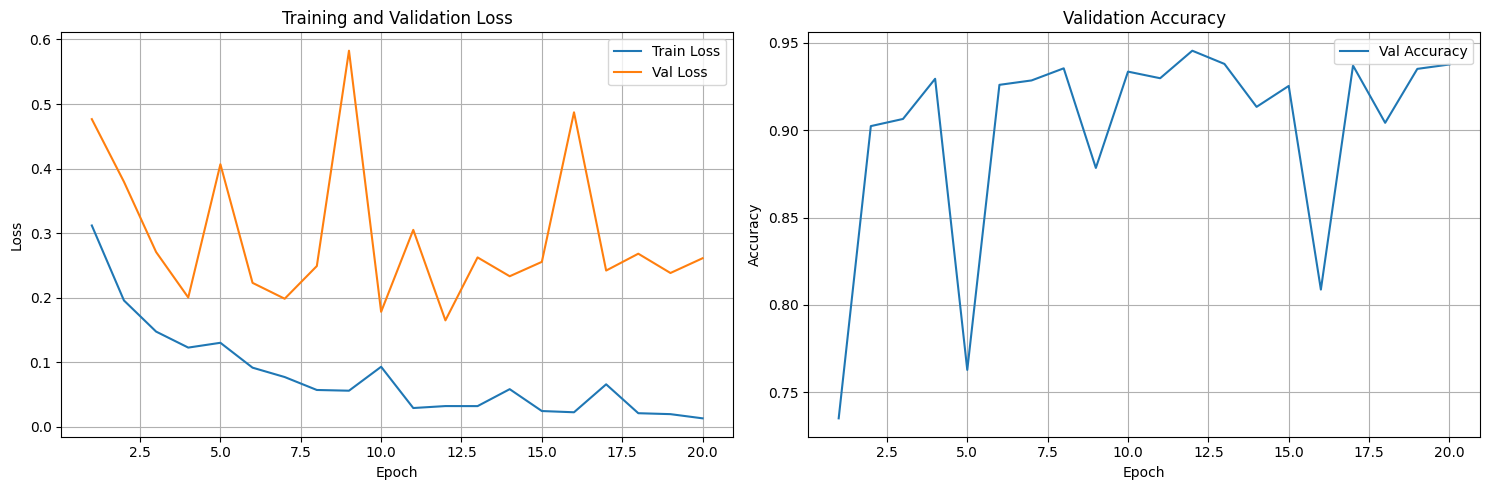

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss curves
ax1.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
ax1.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Accuracy curve
ax2.plot(range(1, num_epochs+1), val_accuracies, label='Val Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

### Training Curves Analysis

**Loss Curves:**
- Training loss decreases smoothly to near zero - model is learning well
- Validation loss is volatile and doesn't decrease consistently
- Large gap between train and val loss indicates **overfitting**
- Val loss spikes at epochs 5, 9, and 16 suggest unstable training

**Accuracy Curve:**
- Validation accuracy fluctuates significantly (76% to 94.5%)
- Best performance at epoch 12 (94.5%), final epoch 20 (93.8%)
- Instability likely due to:
  - Class imbalance (especially small viral pneumonia class)
  - Model memorizing training data (overfitting)

**Improvements for Future:**
- Early stopping at epoch 12 would prevent overfitting
- Add regularization techniques:
  - Dropout layers
  - Weight decay in optimizer
- Learning rate scheduling to stabilize training

### Test Set Evaluation

Final evaluation on held-out test set.

Test Accuracy: 0.9209

Classification Report:
                 precision    recall  f1-score   support

          covid       0.96      0.97      0.97       542
   lung-opacity       0.88      0.87      0.88       902
         normal       0.92      0.93      0.92      1529
viral-pneumonia       0.98      0.97      0.97       202

       accuracy                           0.92      3175
      macro avg       0.94      0.93      0.94      3175
   weighted avg       0.92      0.92      0.92      3175



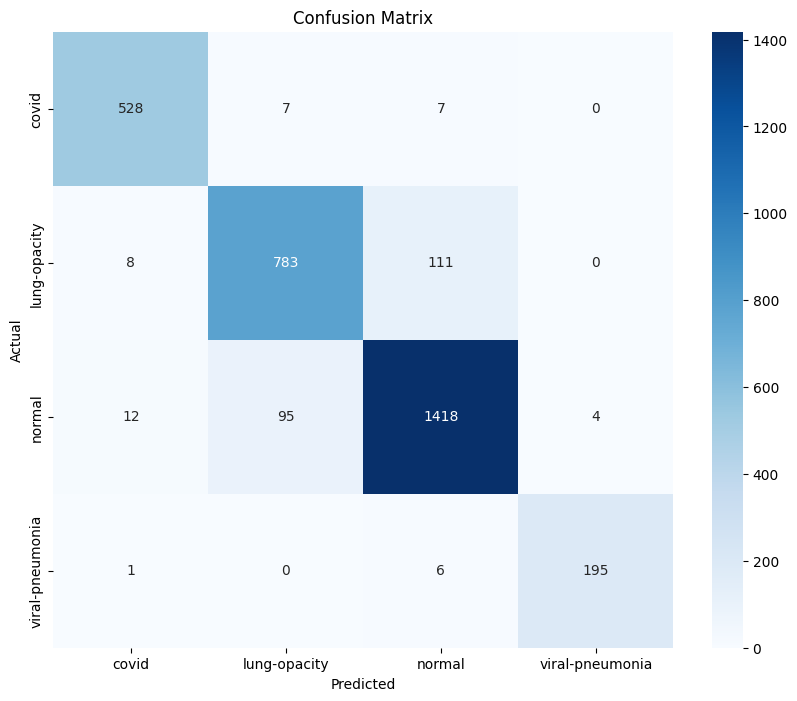

In [23]:
# Evaluate on test set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
test_accuracy = sum([p == l for p, l in zip(all_preds, all_labels)]) / len(all_labels)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=classes))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Results Analysis

**Overall Performance:**
- Test Accuracy: **92.09%**
- Model performs well across all 4 classes despite dataset imbalance

**Per-Class Performance:**
- **COVID-19**: 97% F1-score - Excellent detection with minimal false positives
- **Viral Pneumonia**: 97% F1-score - Best performance despite being smallest class (1,345 images)
- **Normal**: 92% F1-score - Good performance on largest class
- **Lung Opacity**: 88% F1-score - Weakest but still acceptable

**Key Observations from Confusion Matrix:**
- Main confusion: Lung opacity ↔ Normal (206 total cases)
  - 111 lung opacity cases predicted as normal
  - 95 normal cases misclassified as lung opacity
  - This bidirectional confusion makes clinical sense as lung opacity can be subtle
- COVID and viral pneumonia are well-separated (no confusion between them)
- Class weighting successfully handled dataset imbalance

**Clinical Implications:**
- High recall for COVID (97%) is critical for identifying positive cases
- Minimal false positives ensure reliable diagnosis
- Lung opacity confusion with normal requires clinical review in practice

### Save Model

Saving trained model weights for deployment.

In [24]:
# Save model
torch.save(model.state_dict(), 'covid_xray_model.pth')
print("Model saved as 'covid_xray_model.pth'")

Model saved as 'covid_xray_model.pth'


## Showing some predictions

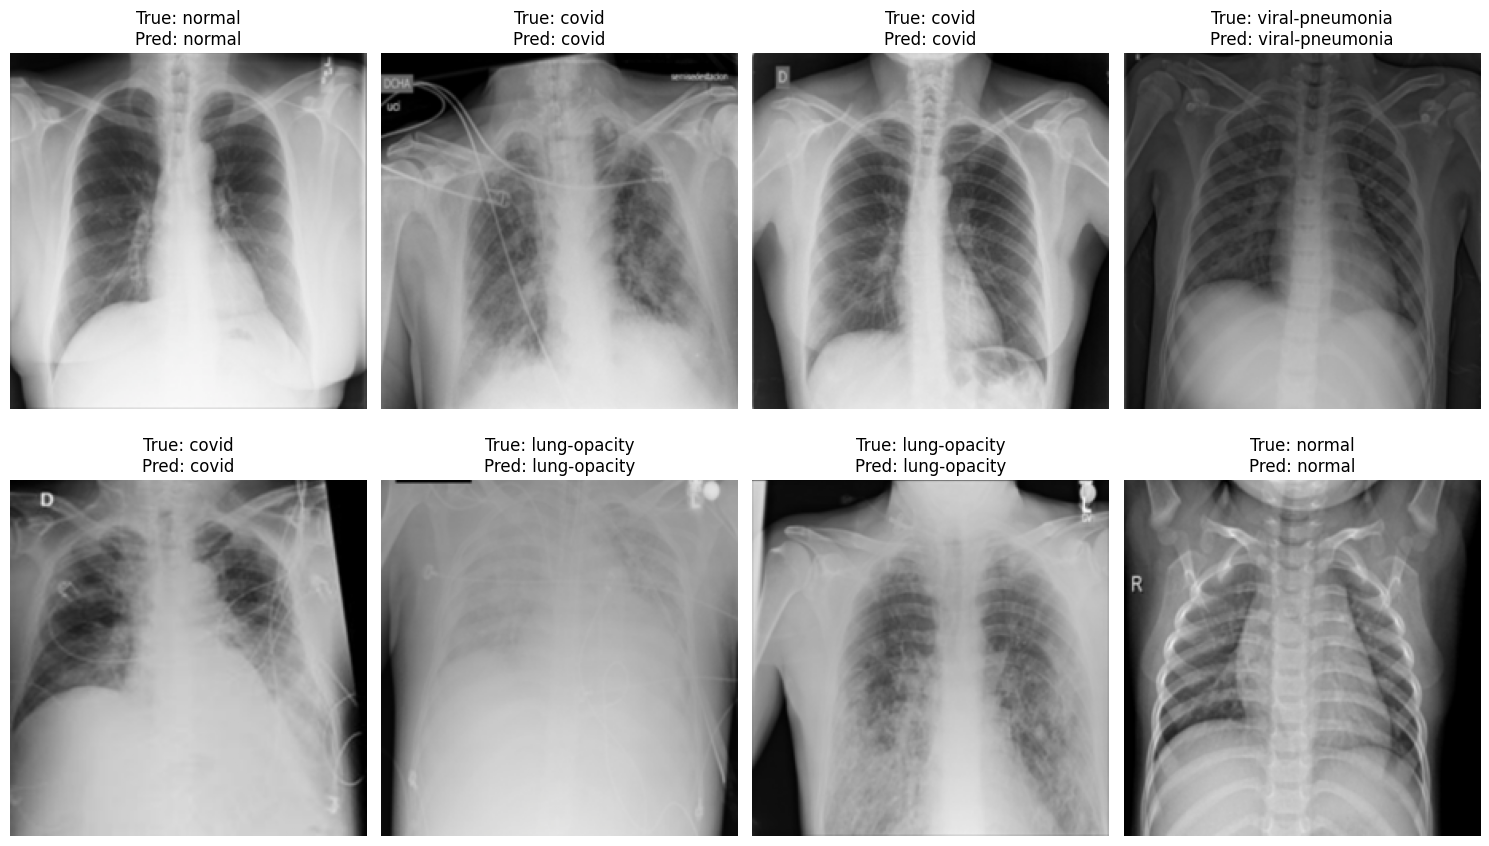

In [27]:
# Show some predictions
fig, axes = plt.subplots(2, 4, figsize=(15, 9))
model.eval()

with torch.no_grad():
    images, labels = next(iter(test_loader))
    images = images.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    
    for i, ax in enumerate(axes.flat):
        img = images[i].cpu().permute(1, 2, 0)
        # Denormalize
        img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
        img = torch.clamp(img, 0, 1)
        
        ax.imshow(img.squeeze(), cmap='gray')
        ax.set_title(f"True: {classes[labels[i]]}\nPred: {classes[predicted[i].cpu()]}")
        ax.axis('off')
        
plt.tight_layout()
plt.show()